In [1]:
import sys
import os


# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

# Change the current working directory to 'src'
src_dir = os.path.join(parent_dir, 'src')
os.chdir(src_dir)

import requests

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO
import pandas  as pd
import numpy as np
import re

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import warnings

warnings.filterwarnings("ignore", message="...", category=FutureWarning)
warnings.filterwarnings("ignore", message="...", category=UserWarning)

seed = 0

In [2]:
df = pd.read_pickle('data/hist/data_modeled.pkl')
print(df.shape)
df.head()

(243, 23)


,work_id,edition_id,cover_url,title,authors,description,subjects,publish_date,genre,unprocessed_img,...,publish_yr,publish_decade,top_3_genres_partitioned_txt,top_3_genres_partitioned,partitioned_pred_txt,partitioned_pred,top_3_genres_merged_txt,top_3_genres_merged,merged_pred_txt,merged_pred
0,OL15450W,OL47243795M,https://covers.openlibrary.org/b/id/13687428-L...,Phantastes,George MacDonald,One of George MacDonald's most important works...,"Fairy tales, Scottish Fantasy fiction, Fiction...","Nov 05, 2019",Fantasy,"[[[126, 25, 41], [125, 24, 40], [124, 21, 38],...",...,2019,2010s,"[Romance, Non-Fiction, Biography]","[5, 4, 0]",Biography,0,"[Romance, Biography, Self-Help]","[5, 0, 7]",Self-Help,7
1,OL27495W,OL49943983M,https://covers.openlibrary.org/b/id/14545200-L...,The Silmarillion,J.R.R. Tolkien,A number-one New York Times bestseller when it...,"Fantasy fiction, Short stories, Middle Earth (...",23 gennaio 2013,Fantasy,"[[[0, 8, 11], [0, 8, 11], [0, 8, 11], [0, 8, 1...",...,2013,2010s,"[Young Adult, Horror, Fantasy]","[10, 2, 1]",Fantasy,1,"[Non-Fiction, Young Adult, Fantasy]","[4, 10, 1]",Fantasy,1
31,OL15437W,OL9785045M,https://covers.openlibrary.org/b/id/14363575-L...,Lilith,George MacDonald,"Lilith, written by the father of fantasy liter...","Fiction, romance, fantasy, Fiction, general, N...",1973-09,Fantasy,"[[[8, 10, 9], [8, 10, 9], [11, 11, 11], [19, 1...",...,1973,1970s,"[Young Adult, Horror, Romance]","[10, 2, 5]",Romance,5,"[Fantasy, Biography, Romance]","[1, 0, 5]",Romance,5
32,OL71124W,OL33336356M,https://covers.openlibrary.org/b/id/11959707-L...,The Last Battle,C.S. Lewis,"For the first time, an edition of Lewis's clas...","Juvenile Fiction, Science Fiction & Fantasy, F...",1986,Fantasy,"[[[138, 130, 117], [139, 131, 118], [140, 132,...",...,1986,1980s,"[Fantasy, Non-Fiction, Young Adult]","[1, 4, 10]",Young Adult,10,"[Non-Fiction, Young Adult, Fantasy]","[4, 10, 1]",Fantasy,1
62,OL1449046W,OL43251544M,https://covers.openlibrary.org/b/id/13135704-L...,The Story of Doctor Dolittle,Hugh Lofting,There are some of us now reaching middle age w...,"Animals, Classic Literature, Children's storie...",2018,Fantasy,"[[[27, 131, 44], [23, 127, 42], [21, 120, 40],...",...,2018,2010s,"[Non-Fiction, Young Adult, Biography]","[4, 10, 0]",Biography,0,"[Non-Fiction, Biography, Fantasy]","[4, 0, 1]",Fantasy,1


In [3]:
df.columns

Index(['work_id', 'edition_id', 'cover_url', 'title', 'authors', 'description',
       'subjects', 'publish_date', 'genre', 'unprocessed_img', 'processed_img',
       'reprocessed_img', 'reprocessed_img_shape', 'publish_yr',
       'publish_decade', 'top_3_genres_partitioned_txt',
       'top_3_genres_partitioned', 'partitioned_pred_txt', 'partitioned_pred',
       'top_3_genres_merged_txt', 'top_3_genres_merged', 'merged_pred_txt',
       'merged_pred'],
      dtype='object')

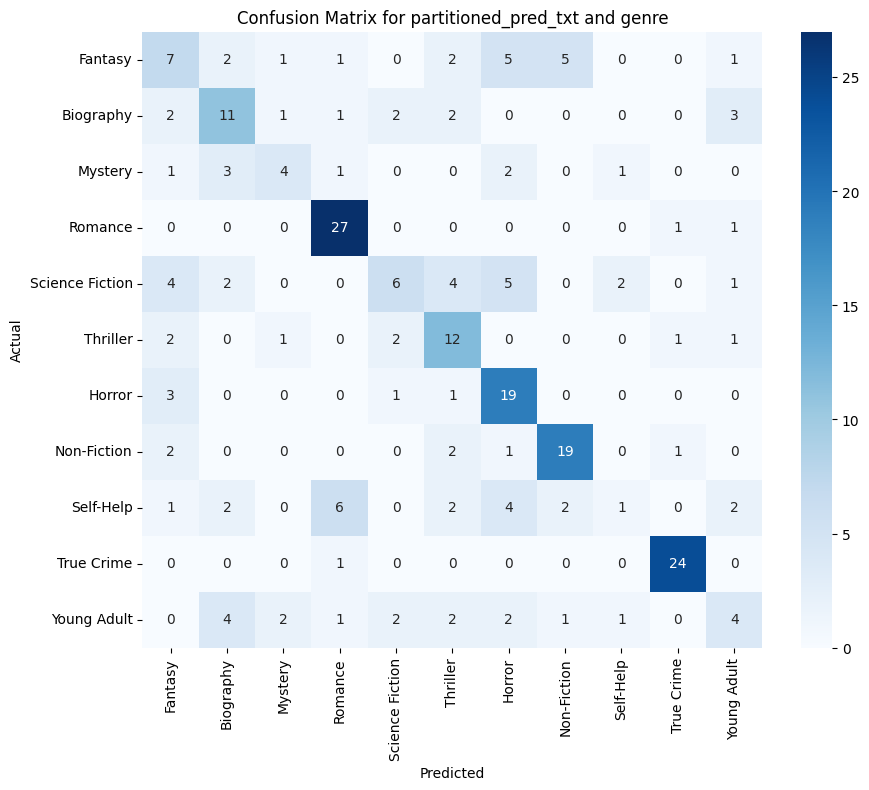

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
conf_matrix = confusion_matrix(df['genre'], df['partitioned_pred_txt'])

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['genre'].unique(), yticklabels=df['genre'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for partitioned_pred_txt and genre')
plt.show()

C:\Users\Jeff\AppData\Local\Temp\ipykernel_15448\235746443.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_decade = grouped.apply(lambda x: (x['genre'] == x['partitioned_pred_txt']).mean())
C:\Users\Jeff\AppData\Local\Temp\ipykernel_15448\235746443.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_decade = grouped.apply(lambda x: pd.Series({


,publish_decade,accuracy,size,decade_int,decade_int_normalized
6,1960s,0.800000,10.0,7,0.000000
7,1970s,0.588235,17.0,8,0.166667
8,1980s,0.500000,14.0,9,0.333333
9,1990s,0.541667,24.0,10,0.500000
10,2000s,0.490909,55.0,11,0.666667
11,2010s,0.514706,68.0,12,0.833333
12,2020s,0.651163,43.0,13,1.000000


C:\Users\Jeff\AppData\Roaming\Python\Python312\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.072
Date:                Fri, 18 Apr 2025   Prob (F-statistic):              0.348
Time:                        13:00:00   Log-Likelihood:                 6.6943
No. Observations:                   7   AIC:                            -9.389
Df Residuals:                       5   BIC:                            -9.497
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8098      0.222      3.644      0.0

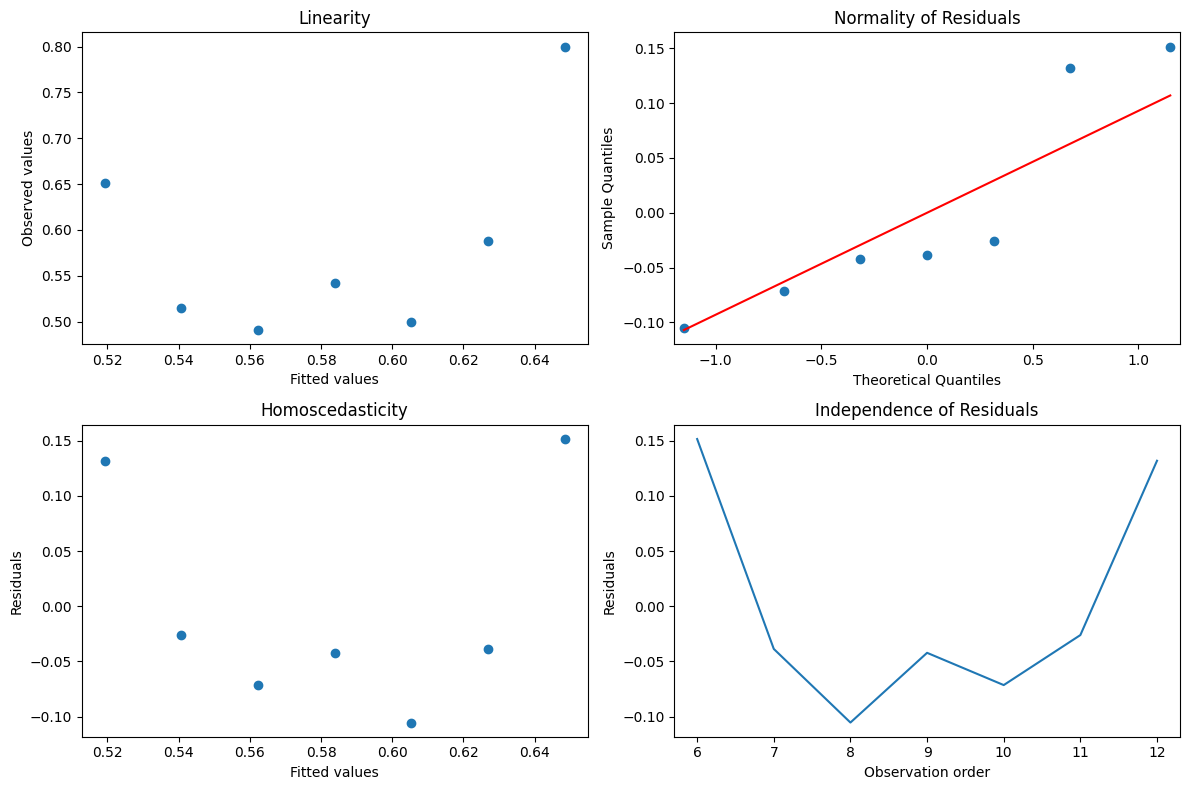

Shapiro-Wilk test: W=0.8288401502583931, p-value=0.07801672487235763


In [5]:
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import scipy.stats as stats

grouped = df.groupby(['publish_decade'])

# Calculate accuracy for each group
accuracy_by_decade = grouped.apply(lambda x: (x['genre'] == x['partitioned_pred_txt']).mean())

# Convert the result to a DataFrame for better readability
accuracy_by_decade = grouped.apply(lambda x: pd.Series({
    'accuracy': (x['genre'] == x['partitioned_pred_txt']).mean(),
    'size': len(x)
})).reset_index()

# Get the unique decades and sort them
unique_decades = sorted(accuracy_by_decade['publish_decade'].unique())

# Create a mapping from decade to integer
decade_mapping = {decade: idx for idx, decade in enumerate(unique_decades)}

# Apply the mapping to the publish_decade column
accuracy_by_decade['decade_int'] = accuracy_by_decade['publish_decade'].map(decade_mapping)
accuracy_by_decade['decade_int'] = accuracy_by_decade['decade_int']+1
accuracy_by_decade = accuracy_by_decade[accuracy_by_decade['size']>=10]

scaler = MinMaxScaler()

accuracy_by_decade['decade_int_normalized'] = scaler.fit_transform(accuracy_by_decade[['decade_int']].astype(int))
display(accuracy_by_decade)

# Extract the dependent and independent variables
X = accuracy_by_decade['decade_int']
y = accuracy_by_decade['accuracy']

X = sm.add_constant(X + 0.5)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

# Plot the residuals
plt.figure(figsize=(12, 8))

# Linearity
plt.subplot(2, 2, 1)
plt.scatter(model.fittedvalues, y)
plt.xlabel('Fitted values')
plt.ylabel('Observed values')
plt.title('Linearity')

# Normality of residuals
plt.subplot(2, 2, 2)
sm.qqplot(model.resid, line='s', ax=plt.gca())
plt.title('Normality of Residuals')

# Homoscedasticity
plt.subplot(2, 2, 3)
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity')

# Independence of residuals
plt.subplot(2, 2, 4)
plt.plot(model.resid)
plt.xlabel('Observation order')
plt.ylabel('Residuals')
plt.title('Independence of Residuals')

plt.tight_layout()
plt.show()

# Perform the Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(model.resid)
print(f'Shapiro-Wilk test: W={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

In [6]:
(df['genre'] == df['merged_pred_txt']).mean()

np.float64(0.51440329218107)

In [7]:
(df['genre'] == df['partitioned_pred_txt']).mean()

np.float64(0.551440329218107)

In [8]:
X.shape, y.shape

((7, 2), (7,))

Optimization terminated successfully.
         Current function value: 0.692771
         Iterations 2
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  243
Model:                          Logit   Df Residuals:                      242
Method:                           MLE   Df Model:                            0
Date:                Fri, 18 Apr 2025   Pseudo R-squ.:              -5.541e-05
Time:                        13:00:01   Log-Likelihood:                -168.34
converged:                       True   LL-Null:                       -168.33
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.745e-05   6.42e-05      0.428      0.669   -9.83e-05       0.000


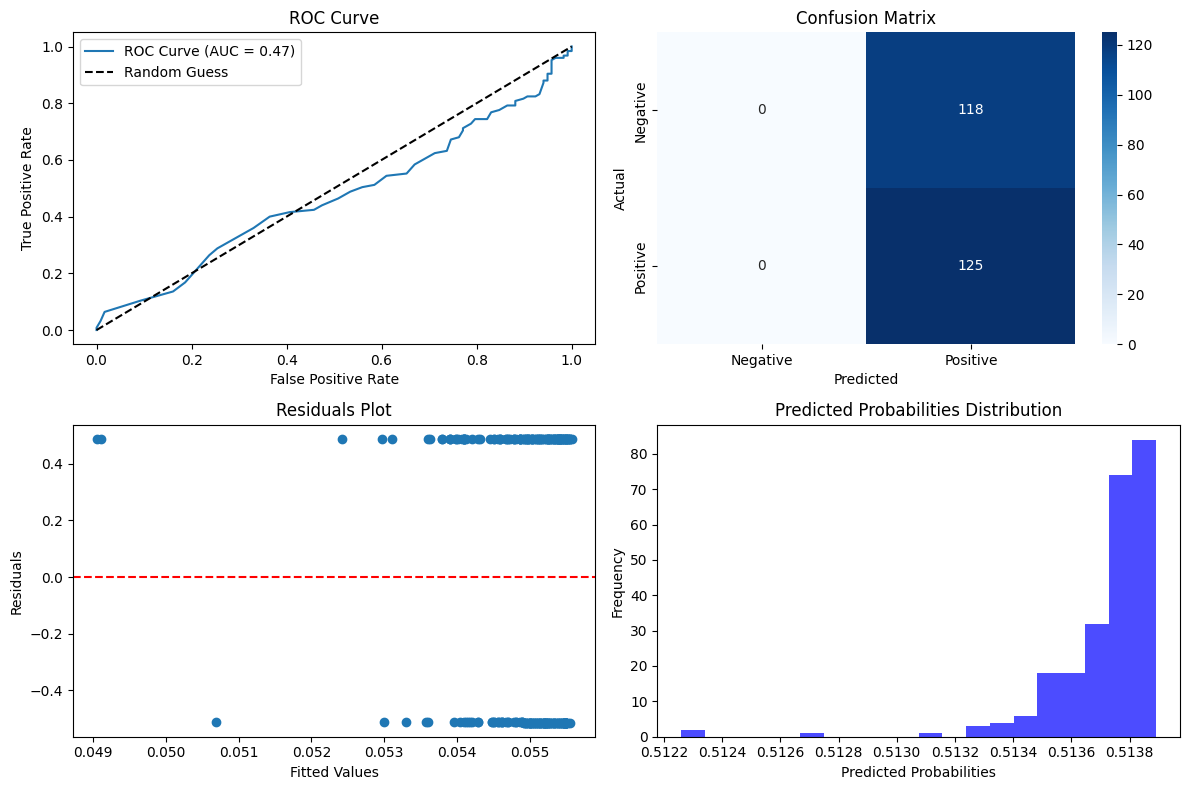

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       118
           1       0.51      1.00      0.68       125

    accuracy                           0.51       243
   macro avg       0.26      0.50      0.34       243
weighted avg       0.26      0.51      0.35       243



In [9]:
# Normalize the publish year for use in the logistic regression model
# X = df['normalized_publish_yr'].values.reshape(-1, 1)
X = df['publish_yr'].astype(int).values.reshape(-1, 1)

y = (df['genre'] == df['merged_pred_txt']).astype(int).values

# Add a constant to the independent variable
# X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

# Print the summary of the model
print(logit_model.summary())

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Generate predicted probabilities and predicted classes
y_pred_prob = logit_model.predict(X)
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))

# ROC Curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred_class)
plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Residuals Plot
plt.subplot(2, 2, 3)
plt.scatter(logit_model.fittedvalues, y - y_pred_prob)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# Predicted Probabilities Histogram
plt.subplot(2, 2, 4)
plt.hist(y_pred_prob, bins=20, color='blue', alpha=0.7)
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Predicted Probabilities Distribution')

plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(y, y_pred_class))


In [10]:
x1            -2.1816      1.159     -1.882      0.060      -4.454       0.091


SyntaxError: invalid syntax (1672413035.py, line 1)

In [ ]:
# Pull the beta value for publish year
beta_publish_yr = 0.0003

# Interpretation of the beta value
interpretation = f"""
The beta value for 'publish_yr' is {beta_publish_yr}. 
This indicates that for every one-year increase in the publication year, 
the predicted probability of the dependent variable (e.g., accuracy or classification correctness) 
increases by {beta_publish_yr * 100:.02f} percentage points, holding all other variables constant.
"""

print(interpretation)


The beta value for 'publish_yr' is 2.1816. 
This indicates that for every one-year increase in the publication year, 
the predicted probability of the dependent variable (e.g., accuracy or classification correctness) 
increases by 218.16 percentage points, holding all other variables constant.



# for fun if we group sci fi and fantasy

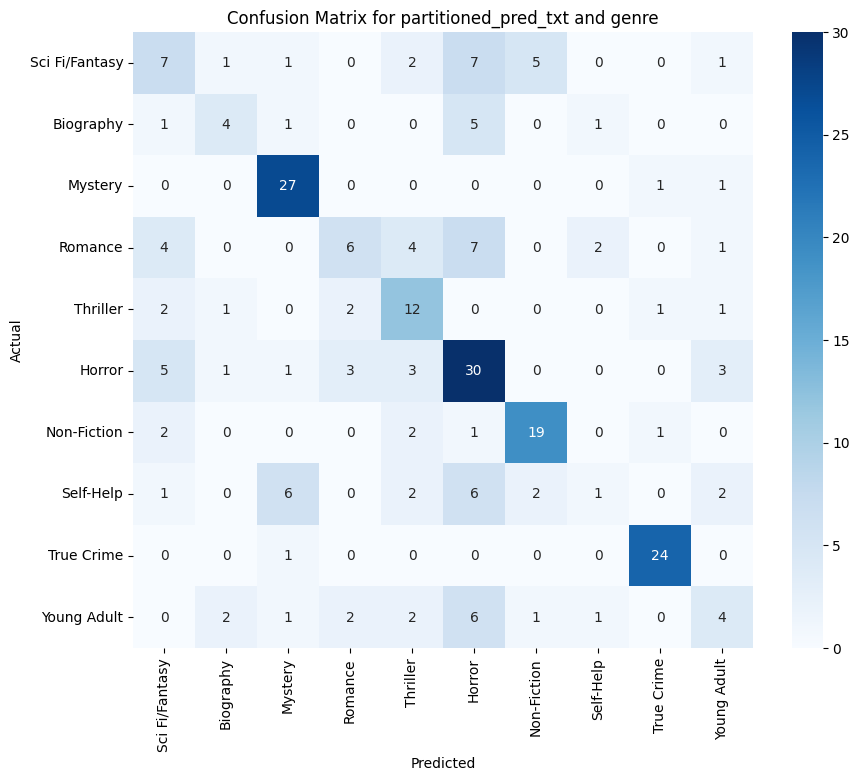

In [ ]:
# Combine 'Fantasy' and 'Science Fiction' genres in actuals
df['genre'] = df['genre'].replace({'Science Fiction': 'Sci Fi/Fantasy'})
df['genre'] = df['genre'].replace({'Fantasy': 'Sci Fi/Fantasy'})

# Combine 'Fantasy' and 'Science Fiction' genres in predictions
df['partitioned_pred_txt'] = df['partitioned_pred_txt'].replace({'Science Fiction': 'Sci Fi/Fantasy'})
df['partitioned_pred_txt'] = df['partitioned_pred_txt'].replace({'Fantasy': 'Sci Fi/Fantasy'})

# Create the confusion matrix
conf_matrix = confusion_matrix(df['genre'], df['partitioned_pred_txt'])

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['genre'].unique(), yticklabels=df['genre'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for partitioned_pred_txt and genre')
plt.show()